# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks

#### Activity 1b: Implementing a Fully Connected Network for Kaggle ASL Dataset

- Objective

The aim of this part of the activity is to apply your understanding of Fully Connected Networks by implementing a multilayer network for the [Kaggle ASL (American Sign Language) dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet). While you have been provided with a complete solution for a Fully Connected Network using Numpy for the MNIST dataset, you are encouraged to try to come up with the solution.

- Instructions

    This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Load and Preprocess Data: You are provided a starter code to load the data. Be sure to understand the code.

    Review MNIST Notebook (Optional): Before diving into this activity, you have the option to revisit the MNIST example to refresh your understanding of how to build a Fully Connected Network using Numpy.

    Start Fresh: Although you can refer to the MNIST solution at any point, try to implement the network for the ASL dataset on your own. This will reinforce your learning and understanding of the architecture and mathematics involved.

    Implement Forward and Backward Pass: Write the code to perform the forward and backward passes, keeping in mind the specific challenges and characteristics of the ASL dataset.
    
     Design the Network: Create the architecture of the Fully Connected Network tailored for the ASL dataset. Choose the number of hidden layers, neurons, and hyperparameters judiciously.

    Train the Model: Execute the training loop, ensuring to track performance metrics such as loss and accuracy.

    Analyze and Document: Use Markdown cells to document in detail the choices you made in terms of architecture and hyperparameters, you may use figures, equations, etc to aid in your explanations. Include any metrics that help justify these choices and discuss the model's performance.  

- Evaluation Criteria

    - Code Readability and Comments
    - Appropriateness of chosen architecture and hyperparameters for the ASL dataset
    - Performance of the model on the ASL dataset (at least 70% acc)
    - Quality of Markdown documentation

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.


In [116]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os

%load_ext autoreload
%autoreload 2
#################################
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
# DATA_PATH = '/media/pepe/DataUbuntu/Databases/asl_data/'
DATA_PATH = './asl_data'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))

In [118]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### Importar Images

In [119]:
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])
del train_df['label']
del valid_df['label']
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

In [120]:
def split_val_test(x, y, pct=0.5, shuffle=True):
    '''
    Create a function that will allow you to split the previously loaded validation set
    into valition and test.
    '''
    x = np.array(x)
    y = np.array(y)

    n = len(y)
    idx = np.arange(n)
    if shuffle:
        np.random.shuffle(idx)
    x = x[idx]
    y = y[idx]

    n_test = int(n * pct)
    x_test = x[:n_test]
    y_test = y[:n_test]
    x_val  = x[n_test:]
    y_val  = y[n_test:]
    return x_val, y_val, x_test, y_test

In [121]:
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)

In [122]:
### The following

alphabet=list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')
print(len(alphabet))

24


### Normalise

In [123]:
x_mean = x_train.mean()
x_std  = x_train.std() + 1e-8

x_train = (x_train - x_mean) / x_std
x_val   = (x_val   - x_mean) / x_std
x_test  = (x_test  - x_mean) / x_std

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(27455, 784) (27455,) (3586, 784) (3586,) (3586, 784) (3586,)


### Graficar muestras

In [124]:
def plot_number(img_28x28):
    plt.figure()
    plt.imshow(img_28x28, cmap='gray')
    plt.axis('off')
    plt.show()

Etiqueta: 5


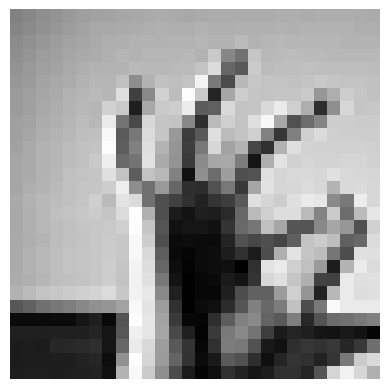

In [125]:
i = np.random.randint(len(x_train))
img = x_train[i].reshape(28, 28)
label = y_train[i]

print("Etiqueta:", label)
plot_number(img)

### Ecuaciones para nuestro modelo


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Funciones adicionales

#### Mini batches

In [126]:
def create_minibatches(mb_size, x, y, shuffle=True):
    n = len(y)
    idx = np.arange(n)
    if shuffle:
        np.random.shuffle(idx)
    for i in range(0, n, mb_size):
        batch_idx = idx[i:i+mb_size]
        yield x[batch_idx], y[batch_idx]

In [127]:
class np_tensor(np.ndarray): pass

In [128]:
a = np.array([0, 0])
b = a.view(np_tensor)

## Nuestra clase Linear, ReLU y Sequential

###  Clase Linear

In [ ]:
class Linear:
    """
    Fully connected (affine) layer implementing:
        Z = W @ X + b

    Initialization
    --------------
    - Weights (W) are initialized with Kaiming He (He normal) scaling suitable for ReLU:
        std = sqrt(2 / fan_in)  ⇔  randn / sqrt(fan_in / 2)
      where fan_in = in_features.
    - Biases (b) are initialized to zeros and broadcast across the batch dimension.

    Expected Shapes (column-major batches)
    --------------------------------------
    - W: (out_features, in_features)
    - b: (out_features, 1)
    - X: (in_features, batch_size)
    - Z: (out_features, batch_size)

    Notes
    -----
    - This implementation assumes tensors support a `.grad` attribute for backpropagation
      (e.g., via a NumPy subclass or a lightweight Tensor wrapper).
    - Gradients computed in `backward` match standard matrix calculus for MSE/CE-style losses:
        dL/dX = W.T @ dL/dZ
        dL/dW = dL/dZ @ X.T
        dL/db = sum(dL/dZ, axis=1, keepdims=True)
    """

    def __init__(self, in_features, out_features):
        # Kaiming He initialization for W: randn / sqrt(in_features/2) -> std = sqrt(2/fan_in)
        self.W = (np.random.randn(out_features, in_features) / np.sqrt(in_features/2)).view(np_tensor)
        # Bias initialized to zeros; will broadcast across columns (batch dimension)
        self.b = (np.zeros((out_features, 1))).view(np_tensor)

    def __call__(self, X):  # forward pass of the Linear layer
        """
        Forward pass.

        Parameters
        ----------
        X : array-like, shape (in_features, batch_size)
            Input activations where each column is a sample.

        Returns
        -------
        Z : array-like, shape (out_features, batch_size)
            Linear transformation result Z = W @ X + b
            (bias b is broadcast over the batch dimension).
        """
        Z = self.W @ X + self.b
        return Z

    def backward(self, X, Z):
        """
        Backward pass given upstream gradient stored in `Z.grad` (∂L/∂Z).

        Parameters
        ----------
        X : array-like, shape (in_features, batch_size)
            The same input that was used in the forward pass.
        Z : array-like, shape (out_features, batch_size)
            The output from the forward pass; must carry `Z.grad` as the upstream gradient.

        Side Effects
        ------------
        - Populates:
            X.grad : (in_features, batch_size)   with  dL/dX = W.T @ dL/dZ
            W.grad : (out_features, in_features) with  dL/dW = dL/dZ @ X.T
            b.grad : (out_features, 1)           with  dL/db = sum(dL/dZ, axis=1, keepdims=True)
        """
        # Z.grad is defined by the next layer (or by the loss for the final layer)
        X.grad = self.W.T @ Z.grad
        self.W.grad = (Z.grad @ X.T)
        self.b.grad = np.sum(Z.grad, axis=1, keepdims=True)

### Clase ReLU

In [ ]:
class ReLU:
    """
    Rectified Linear Unit (ReLU) activation layer.

    This layer applies the element-wise transformation:
        ReLU(z) = max(0, z)

    Interface
    ---------
    - Forward pass via __call__(Z) -> A
      * Z: pre-activation input (any real-valued array-like)
      * A: activation output with the same shape as Z

    - Backward pass via backward(Z, A)
      * Z: the same tensor passed to the forward pass (pre-activation)
      * A: the output tensor produced by the forward pass; it is expected
           to carry the upstream gradient in `A.grad` (i.e., ∂L/∂A)
      * This method writes the downstream gradient into `Z.grad`:
           ∂L/∂Z = (Z > 0) ⊙ ∂L/∂A

    Notes
    -----
    - This implementation assumes tensors support a `.grad` attribute
      (e.g., via a NumPy subclass or a lightweight Tensor wrapper).
    - ReLU's derivative is 1 where Z > 0 and 0 elsewhere (commonly 0 at Z = 0).
    """

    def __call__(self, Z):
        # Forward pass: apply ReLU element-wise (clamp negatives to zero)
        return np.maximum(0, Z)

    def backward(self, Z, A):
        # Backward pass: start from upstream gradient ∂L/∂A
        Z.grad = A.grad.copy()

        # Mask gradient where the pre-activation Z is <= 0
        Z.grad[Z <= 0] = 0

### Clase Sequential

In [ ]:
class Sequential_layers:
    """
    A simple sequential container to compose layers into a feed-forward network.

    This class chains together a list of layer objects that implement a common
    interface:
        - Forward pass via `__call__(X) -> Y`
        - Backward pass via `backward(inp, out)`, where:
            * `inp` is the input tensor passed to the layer during the forward pass
            * `out` is the output tensor produced by the layer during the forward pass
              and is expected to carry `.grad` set by the next layer (or the loss for the last layer).

    The container:
      - Runs the forward pass left-to-right, caching each layer's output in `self.outputs`
        using keys "l0", "l1", ..., "lN".
      - Runs the backward pass right-to-left, calling each layer's `backward` with the
        cached input/output tensors.
      - Provides a parameter update step for `Linear` layers (SGD), and a convenience
        `predict` method for single-column inputs.

    Notes
    -----
    - This implementation assumes tensors can carry a `.grad` attribute (e.g., via a
      NumPy subclass or a lightweight Tensor wrapper).
    - The `update` method currently *reassigns* `W` and `b` (not in-place), which can
      discard attributes like `.grad` on those arrays. If you rely on persisting `.grad`
      across steps, consider in-place updates (e.g., `layer.W -= lr * layer.W.grad`).
    - The `predict` method expects a single example shaped as a column vector
      `(in_features, 1)` and returns the argmax class index as `int`.
    """

    def __init__(self, layers):
        """
        Initialize the sequential container.

        Parameters
        ----------
        layers : list
            Ordered list of layer objects. Each layer must implement:
                - `__call__(X)` for forward propagation
                - `backward(inp, out)` for backpropagation
            Layers like `Linear` are expected to own parameters (e.g., W, b) and
            their gradients, while activation layers (e.g., ReLU) are typically
            parameter-free.
        """
        # Store the sequence of layers and a cache for intermediate outputs
        self.layers = layers
        self.outputs = {}

    def __call__(self, X):
        """
        Perform a forward pass through all layers and cache intermediate outputs.

        Parameters
        ----------
        X : array-like
            Network input for the first layer. Conventionally shaped as
            `(in_features, batch_size)` so that each column is a sample.

        Returns
        -------
        array-like
            The final output of the last layer (e.g., logits).
            The method also populates `self.outputs` with:
              - 'l0' = X (the original input)
              - 'l1' = output of layer 1
              - ...
              - 'lN' = output of the last layer
        """
        # Forward pass through all layers, caching each layer's output
        self.outputs['l0'] = X            # Cache network input as layer 0 output
        out = X
        for i, layer in enumerate(self.layers, start=1):
            out = layer(out)              # Apply layer i to the previous output
            self.outputs[f'l{i}'] = out   # Cache current layer output
        return out                         # Final output (e.g., logits)

    def backward(self):
        """
        Perform a backward pass through all layers in reverse order.

        Requirements
        ------------
        - The final output tensor (cached as `self.outputs['lN']`) must already have
          its `.grad` attribute set by the loss function (i.e., dL/dOut).
        - Each layer's `backward(inp, out)` is responsible for:
            * Reading `out.grad` (upstream gradient)
            * Writing `inp.grad` (downstream gradient)
            * Accumulating parameter gradients (e.g., `W.grad`, `b.grad`) if the
              layer has learnable parameters.
        """
        # Backward pass: iterate layers in reverse order
        # Assumes the final output (self.outputs['lN']) already has .grad set by the loss
        for i in range(len(self.layers), 0, -1):
            layer = self.layers[i-1]              # Current layer (from last to first)
            inp = self.outputs[f'l{i-1}']         # Input to this layer during forward
            out = self.outputs[f'l{i}']           # Output from this layer during forward
            layer.backward(inp, out)              # Propagate gradients through the layer

    def update(self, lr):
        """
        Apply a single SGD update step to parameters of supported layers.

        Parameters
        ----------
        lr : float
            Learning rate for the update step. For each `Linear` layer:
                W <- W - lr * W.grad
                b <- b - lr * b.grad

        Notes
        -----
        - This implementation *reassigns* `W` and `b` with new arrays via `.view(np_tensor)`.
          Reassignment can drop previously attached attributes (e.g., `.grad`). If you need
          to preserve such attributes, consider performing updates in-place.
        """
        # Parameter update step for layers that have weights/biases (Linear layers)
        # NOTE: This reassigns arrays rather than updating in-place; be careful with .grad persistence.
        for layer in self.layers:
            if isinstance(layer, Linear):
                layer.W = (layer.W - lr * layer.W.grad).view(np_tensor)
                layer.b = (layer.b - lr * layer.b.grad).view(np_tensor)

    def predict(self, x_col):
        """
        Predict the class index for a single input column.

        Parameters
        ----------
        x_col : array-like
            Single example shaped as a column vector `(in_features, 1)`.
            The data will be forwarded through the network to produce scores.

        Returns
        -------
        int
            The predicted class index given by `argmax` over the class dimension.

        Notes
        -----
        - This method is intended for single-sample inference. For batched inference,
          call the instance directly (i.e., `scores = model(X)`) and apply `argmax`
          across axis=0 to obtain class predictions for each column.
        """
        # Run a forward pass for a single column input (shape: features x 1)
        # and return the predicted class index (argmax over classes)
        scores = self(x_col.view(np_tensor))
        return int(np.argmax(scores, axis=0)[0])

### Cost Function

In [132]:
def softmaxXEntropy(x, y):
    """
    Compute softmax probabilities and cross-entropy loss, and store the gradient dL/dx in `x.grad`.

    Parameters
    ----------
    x : np.ndarray
        Logits (pre-softmax scores) with shape (num_classes, batch_size).
        Each column corresponds to one sample in the batch.
        NOTE: This function assumes that `x` can hold an attribute `.grad`
        (e.g., a NumPy subclass or a wrapper that allows setting attributes).

    y : np.ndarray
        Integer class labels for the batch, shape (batch_size,) or (batch_size, 1).
        Values must be in the range [0, num_classes-1]. If shape is (batch_size, 1),
        it will be squeezed to (batch_size,).

    Returns
    -------
    preds : np.ndarray
        Softmax class probabilities with shape (num_classes, batch_size).
        Each column sums to 1.
    cost : float
        Mean cross-entropy loss over the batch.

    Side Effects
    ------------
    - Writes the gradient of the loss with respect to the logits into `x.grad`,
      i.e., dL/dx = softmax(x) - one_hot(y), as implemented below.
      NOTE: The current implementation does NOT divide the gradient by `batch_size`,
      while the loss is averaged.

    Notes
    -----
    - Numerical stability: for production code, it is standard to shift logits by
      their per-column maximum before exponentiation (log-sum-exp trick). Here we
      keep the naive exponentiation to preserve the original code.
    - If you encounter `log(0)` due to extremely small probabilities, adding a small
      epsilon inside the log (e.g., 1e-12) is a common safeguard.
    """

    # Determine batch size from logits tensor shaped (num_classes, batch_size)
    batch_size = x.shape[1]

    # Compute unnormalized scores via exponentiation (softmax numerator)
    # NOTE: This is the naive form; in practice you would shift by max(x) per column for numerical stability.
    exp_scores = np.exp(x)

    # Normalize across classes to obtain probabilities (softmax denominator sums over axis=0 = per sample)
    probs = exp_scores / exp_scores.sum(axis = 0)

    # Keep a copy of probabilities to return as predictions
    preds = probs.copy()

    # ----- Cross-Entropy Loss -----
    # Gather the predicted probability for the true class of each sample
    y_hat = probs[y.squeeze(), np.arange(batch_size)]

    # Compute mean cross-entropy loss over the batch
    # NOTE: Adding a small epsilon inside log is common to avoid log(0), but we keep code unchanged here.
    cost = np.sum(-np.log(y_hat)) / batch_size

    # ----- Gradient w.r.t. logits (dL/dx) -----
    # For softmax + cross-entropy, gradient is: probs - one_hot(y)
    # Here we subtract 1 at the true class index for each sample
    probs[y.squeeze(), np.arange(batch_size)] -= 1  # dl/dx

    # Store gradient in x.grad for backpropagation through previous layers
    # NOTE: If loss is averaged over batch, dividing by batch_size here is typical; preserved as-is per base code.
    x.grad = probs.copy()

    # Return probabilities (preds) and scalar loss (cost)
    return preds, cost

### Loop de entrenamiento

In [133]:
def train(model, epochs, mb_size=128, learning_rate = 1e-3):
    # Train the model for a given number of epochs using mini-batch SGD.
    # Notes:
    # - 'scores' are the logits returned by the model.
    # - softmaxXEntropy(scores, y) computes the loss and seeds scores.grad.
    # - model.backward() backpropagates through all layers.
    # - model.update(learning_rate) applies an SGD step to parameters.
    for epoch in range(epochs):
        # Iterate over training data in mini-batches
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):
            # Forward pass: model expects (features, batch), so we transpose the batch
            scores = model(x.T.view(np_tensor))
            # Compute softmax cross-entropy loss and seed gradient on the final scores
            _, cost = softmaxXEntropy(scores, y)
            # Backpropagate gradients through the network
            model.backward()
            # Update parameters with the chosen learning rate
            model.update(learning_rate)
        # Friendly, English summary per epoch (shows the last batch loss and current validation accuracy)
        print(f"Epoch {epoch+1}/{epochs} — Last batch loss: {cost:.4f} | "
              f"Validation accuracy: {accuracy(x_val, y_val, mb_size)*100:.2f}%")

In [134]:
def accuracy(x, y, mb_size):
    # Initialize counters for correct predictions and total samples
    correct = 0
    total = 0

    # Iterate over the dataset in mini-batches
    for i, (x, y) in enumerate(create_minibatches(mb_size, x, y)):
        # Forward pass: the model expects input shaped as (features, batch), so we transpose
        pred = model(x.T.view(np_tensor))

        # Count how many predictions match the true labels
        correct += np.sum(np.argmax(pred, axis=0) == y.squeeze())

        # Increase the total number of processed samples (batch size)
        total += pred.shape[1]

    # Return overall accuracy as correct predictions divided by total samples
    return correct/total

### Create your model and train it

In [135]:
model = Sequential_layers([Linear(784, 256), ReLU(), Linear(256, 128), ReLU(), Linear(128, 24)])
mb_size = 512
learning_rate = 1e-3
epochs = 25


In [136]:
train(model, epochs, mb_size, learning_rate)

Epoch 1/25 — Last batch loss: 0.1792 | Validation accuracy: 76.60%
Epoch 2/25 — Last batch loss: 0.0197 | Validation accuracy: 78.44%
Epoch 3/25 — Last batch loss: 0.0104 | Validation accuracy: 78.95%
Epoch 4/25 — Last batch loss: 0.0068 | Validation accuracy: 79.28%
Epoch 5/25 — Last batch loss: 0.0050 | Validation accuracy: 79.89%
Epoch 6/25 — Last batch loss: 0.0042 | Validation accuracy: 79.87%
Epoch 7/25 — Last batch loss: 0.0026 | Validation accuracy: 79.73%
Epoch 8/25 — Last batch loss: 0.0031 | Validation accuracy: 79.95%
Epoch 9/25 — Last batch loss: 0.0023 | Validation accuracy: 80.17%
Epoch 10/25 — Last batch loss: 0.0017 | Validation accuracy: 80.23%
Epoch 11/25 — Last batch loss: 0.0018 | Validation accuracy: 79.95%
Epoch 12/25 — Last batch loss: 0.0014 | Validation accuracy: 80.34%
Epoch 13/25 — Last batch loss: 0.0015 | Validation accuracy: 80.20%
Epoch 14/25 — Last batch loss: 0.0011 | Validation accuracy: 80.45%
Epoch 15/25 — Last batch loss: 0.0010 | Validation accura

In [137]:
# Compute test accuracy with mini-batches
test_acc = accuracy(x_test, y_test, mb_size)

# Nicely formatted output
print(f"TEST ACCURACY: {test_acc * 100:.2f}% ({test_acc:.4f})")

TEST ACCURACY: 81.48% (0.8148)


### Test your model on Random data from your test set

In [138]:
def test_random_samples(n=5, seed=None):
    """
    Run n random prediction tests on the test set.
    
    Parameters
    ----------
    n : int
        Number of random samples to test.
    seed : int or None
        Optional random seed for reproducibility.
    """
    if seed is not None:
        np.random.seed(seed)

    correct = 0

    for t in range(1, n + 1):
        # Pick a random test sample index
        idx = np.random.randint(len(y_test))

        # Visualize the corresponding 28x28 grayscale image
        plot_number(x_test[idx].reshape(28, 28))

        # Prepare the sample as a column vector (features, 1) and get the predicted class index
        pred = model.predict(x_test[idx].reshape(-1, 1))

        # Map class indices to letters for readability
        pred_letter = alphabet[pred]
        true_letter = alphabet[y_test[idx]]

        # Determine if the prediction matches the ground truth
        status = "CORRECT" if pred == y_test[idx] else "INCORRECT"
        correct += (status == "CORRECT")

        # Print a clear, uppercase status along with predicted vs. true labels
        print(f"[{t}/{n}] PREDICTION: {pred_letter} | TRUE: {true_letter} | STATUS: {status}")

    # Summary of the mini test session
    print(f"\nSUMMARY: {correct}/{n} correct "
          f"({100.0 * correct / max(1, n):.2f}% accuracy over random samples)")


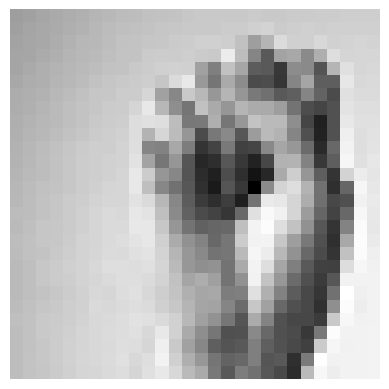

[1/10] PREDICTION: s | TRUE: s | STATUS: CORRECT


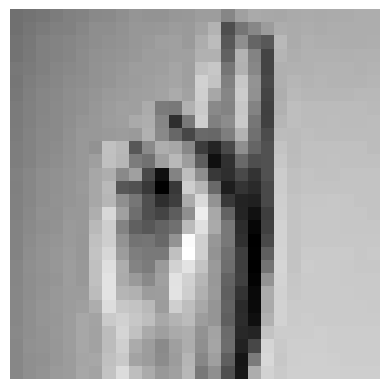

[2/10] PREDICTION: k | TRUE: u | STATUS: INCORRECT


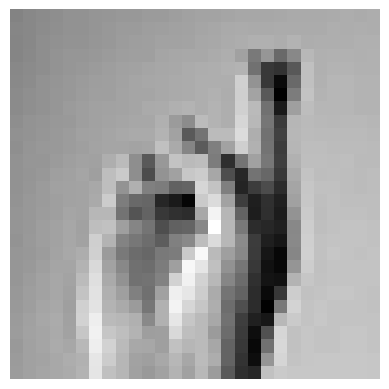

[3/10] PREDICTION: r | TRUE: r | STATUS: CORRECT


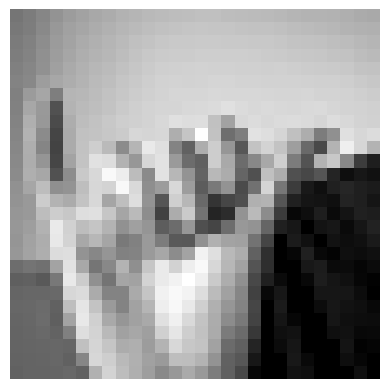

[4/10] PREDICTION: y | TRUE: y | STATUS: CORRECT


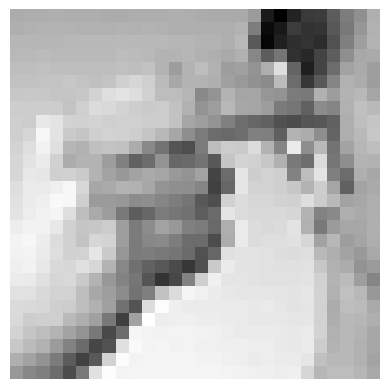

[5/10] PREDICTION: h | TRUE: h | STATUS: CORRECT


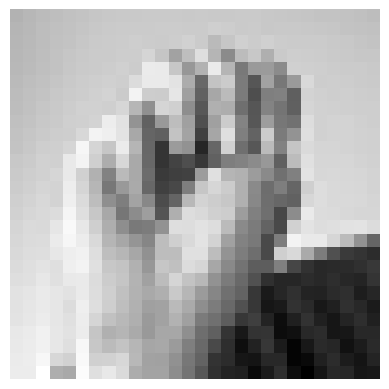

[6/10] PREDICTION: m | TRUE: m | STATUS: CORRECT


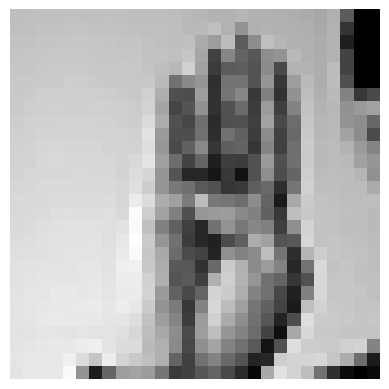

[7/10] PREDICTION: b | TRUE: b | STATUS: CORRECT


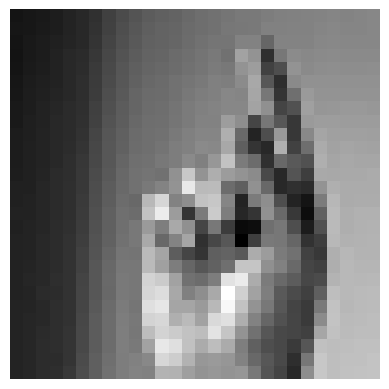

[8/10] PREDICTION: k | TRUE: k | STATUS: CORRECT


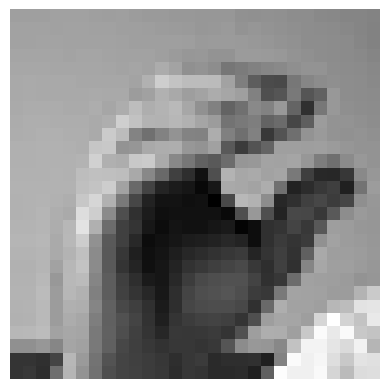

[9/10] PREDICTION: c | TRUE: c | STATUS: CORRECT


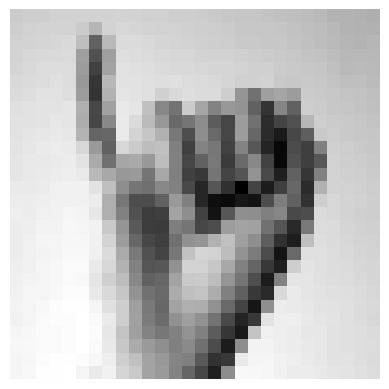

[10/10] PREDICTION: i | TRUE: i | STATUS: CORRECT

SUMMARY: 9/10 correct (90.00% accuracy over random samples)


In [139]:
test_random_samples(n=10, seed=42)